<a href="https://colab.research.google.com/github/deltorobarba/science/blob/main/ibm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Quantum Computing with IBM**

In [ ]:
!pip install qiskit qiskit-ibm-runtime qiskit[visualization] -q
import matplotlib.pyplot as plt
import numpy as np
from google.colab import userdata
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit import QuantumCircuit
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit.visualization import plot_histogram
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

In [ ]:
# 1. Retrieve API key
api_token = userdata.get('ibm-quantum')

# 2. Connect to IBM Quantum
service = QiskitRuntimeService(channel='ibm_quantum_platform', token=api_token)

In [ ]:
# 3. List available backends

# service.backends(simulator=False, operational=True) # simple list all backends
# backend = service.least_busy(simulator=False, operational=True) # let backend choose automatically

print(f"{'Backend Name':<30} | {'Qubits':<10} | {'Status':<10}" + "\n" + "-" * 55)
for b in service.backends():
    status = "Online" if b.status().operational else "Offline"
    print(f"{b.name:<30} | {b.num_qubits:<10} | {status:<10}")

qiskit_runtime_service.backends:WARNING:2026-01-05 15:14:01,943: Loading instance: einstein, plan: pay-as-you-go


Backend Name                   | Qubits     | Status    
-------------------------------------------------------
ibm_strasbourg                 | 127        | Online    
ibm_aachen                     | 156        | Online    
ibm_brussels                   | 127        | Online    


In [ ]:
# 4. Select backend (quantum or simulator)
backend = service.backend('ibm_strasbourg')
print(f"Selected backend: {backend.name}")

qiskit_runtime_service.backends:WARNING:2026-01-05 15:16:04,359: Using instance: einstein, plan: pay-as-you-go


Selected backend: ibm_strasbourg


**Unequal Superposition Experiment**
Creating non-uniform probability distributions by combining standard superposition gates with rotation gates.
* **Circuit:**
    1.  **Unequal Superposition:** $R_y(\pi/3)$ on $q_0 \rightarrow \frac{\sqrt{3}}{2}|0\rangle + \frac{1}{2}|1\rangle$.
    2.  **Equal Superposition:** $H$ on $q_1 \rightarrow \frac{1}{\sqrt{2}}(|0\rangle + |1\rangle)$.
    3.  **Bit-Flip:** $X$ on $q_3$ flips MSB $|0...\rangle \rightarrow |1...\rangle$.
    4.  **Entanglement:** $CX_{0,2}$ flips $q_2$ if $q_0$ is $|1\rangle$.
* **Final State:** $|\psi_{final}\rangle = \frac{\sqrt{3}}{2\sqrt{2}}|1000\rangle + \frac{\sqrt{3}}{2\sqrt{2}}|1010\rangle + \frac{1}{2\sqrt{2}}|1101\rangle + \frac{1}{2\sqrt{2}}|1111\rangle$
* **Probabilities ($P = |\text{amplitude}|^2$):**
    * $|1000\rangle, |1010\rangle$: $P = |\frac{\sqrt{3}}{2\sqrt{2}}|^2 = 3/8 = \textbf{37.5\%}$
    * $|1101\rangle, |1111\rangle$: $P = |\frac{1}{2\sqrt{2}}|^2 = 1/8 = \textbf{12.5\%}$


Ideal Circuit Diagram:


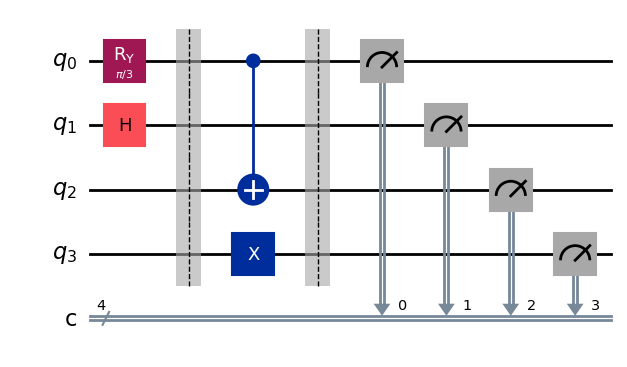

In [ ]:
# 4. Define Quantum Circuit (Asymmetric State Evolution with Unequal Superposition)
qc = QuantumCircuit(4, 4)
qc.ry(np.pi / 3, 0) # Replace H(0) with Ry(pi/3, 0) to create a 75%/25% split
qc.h(1)             # Keep the H on q1 for a 50/50 split
qc.barrier()
qc.cx(0, 2)
qc.x(3)
qc.barrier()
qc.measure([0, 1, 2, 3], [0, 1, 2, 3])
print("\nIdeal Circuit Diagram:")
display(qc.draw("mpl"))


Transpiled Circuit for ibm_strasbourg:


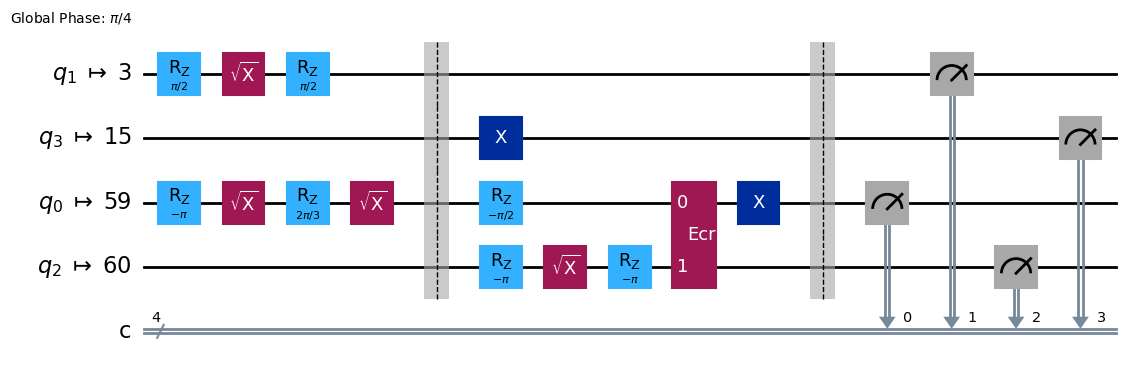

In [ ]:
# 5. Transpile circuit for backend (translates ideal circuit into one the hardware can run)
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)
print(f"\nTranspiled Circuit for {backend.name}:")
display(isa_circuit.draw("mpl"))

In [ ]:
# 6. Run job on IBM quantum computer
sampler = Sampler(mode=backend)
shots = 1024
print(f"\nSubmitting job to {backend.name}...")
job = sampler.run(pubs=[(isa_circuit,)], shots=shots) # Run transpiled 'isa_circuit', not original 'qc'
print(f"Job submitted successfully! Job ID: {job.job_id()}")


Submitting job to ibm_strasbourg...
Job submitted successfully! Job ID: d5dtbprgr59c73867bag


In [ ]:
job.status()

'RUNNING'

In [ ]:
job.status()

'DONE'

In [ ]:
job.metrics()

{'timestamps': {'created': '2026-01-05T15:16:55.943779Z',
  'finished': '2026-01-05T15:17:01.301017Z',
  'running': '2026-01-05T15:16:56.628197Z'},
 'bss': {'seconds': 2},
 'usage': {'quantum_seconds': 2, 'seconds': 2},
 'qiskit_version': 'qiskit_ibm_runtime-0.44.0,qiskit-2.2.3*',
 'caller': 'qiskit_ibm_runtime~sampler.py'}

In [ ]:
job.result()

PrimitiveResult([SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=1024, num_bits=4>)), metadata={'circuit_metadata': {}})], metadata={'execution': {'execution_spans': ExecutionSpans([DoubleSliceSpan(<start='2026-01-05 15:16:58', stop='2026-01-05 15:17:00', size=1024>)])}, 'version': 2})


Measurement Results (Counts):
{'1000': 402, '1101': 132, '1010': 347, '0000': 4, '1111': 112, '1100': 5, '1110': 7, '1011': 6, '1001': 2, '0010': 5, '0111': 1, '0101': 1}


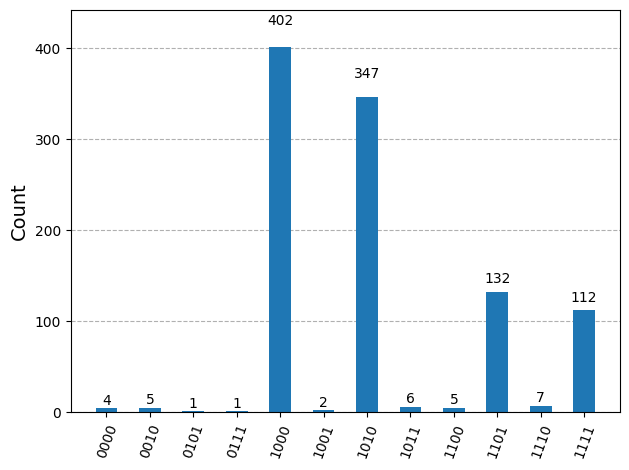

In [ ]:
# 7. Get and display results
result = job.result()
counts = result[0].data.c.get_counts()
print("\nMeasurement Results (Counts):")
print(counts)
plot_histogram(counts)


Local Simulation results (counts) with 1024 shots:
{'1000': 367, '1010': 401, '1111': 110, '1101': 146}

Probabilities:
  |1000>: 0.358 (367/1024)
  |1010>: 0.392 (401/1024)
  |1101>: 0.143 (146/1024)
  |1111>: 0.107 (110/1024)


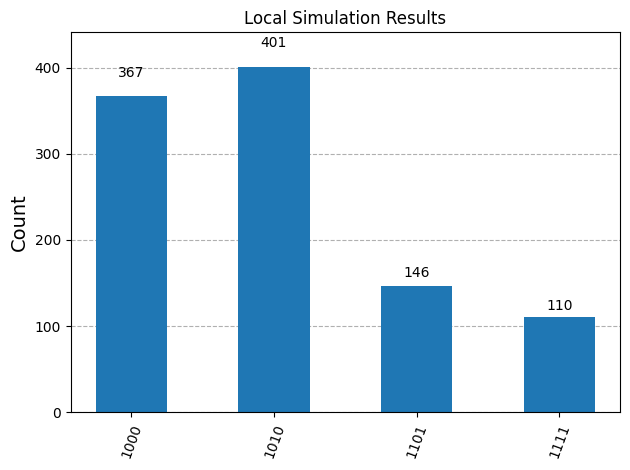

In [ ]:
# 8. Run simulation (for comparison)
from qiskit.primitives import StatevectorSampler as LocalSampler
from qiskit.visualization import plot_histogram

local_sampler = LocalSampler() # Create local sampler
local_shots = 1024
local_job = local_sampler.run(pubs=[(qc,)], shots=local_shots) # Run circuit
local_result = local_job.result()
local_counts = local_result[0].data.c.get_counts() # Extract counts from result
print(f"\nLocal Simulation results (counts) with {local_shots} shots:")
print(local_counts)
print("\nProbabilities:")
for bitstring, count in sorted(local_counts.items()):
    probability = count / local_shots
    print(f"  |{bitstring}>: {probability:.3f} ({count}/{local_shots})")

display(plot_histogram(local_counts, title="Local Simulation Results"))

In [ ]:
# Devices:  https://eu-de.quantum.cloud.ibm.com/computers
# Topology: https://eu-de.quantum.cloud.ibm.com/docs/de/guides/qpu-information
# Jobs:     https://eu-de.quantum.cloud.ibm.com/workloads
# Cost:     https://cloud.ibm.com/billing
# Tutorial: https://eu-de.quantum.cloud.ibm.com/docs/de/tutorials